# A/B testing 

In [1]:
from scipy.stats import chi2_contingency#chisquare
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

$\texttt{conversion ratio(CR)} = \frac{\texttt{Number of conversions}}{\texttt{Total visitors}} \times 100 \%$

A/B test hypothesis:

$H_0$:CR(B) $\leq$ CR(A)

$H_1$:CR(B) $>$ CR (A)

$Chi^{2} = \frac{(o -co - \frac{o \times nf}{n})^{2}}{\frac{o \times nf}{n}} + \frac{(v -cv - \frac{v \times nf}{n})^{2}}{\frac{v \times nf}{n}} + \frac{(co - \frac{o \times nc}{n})^{2}}{\frac{o \times nc}{n}} + \frac{(cv - \frac{v \times nc}{n})^{2}}{\frac{v \times nc}{n}}$

o: Visitors of A

v: Visitors of B

co: Conversions of A

cv: Conversions of B

n: Total number of Visitors

nf: Total number of Visitors without conversion

nc: Total number of Visitors with conversion

(we can get the number by contingency table and conversion ratio )

We assume the conversion ratio of A is 5% and the conversion ratio of B is 8%. And we run A/B test by Chi-square test

The total conversions (TC) during the exploration test with N vistors pre variation is :

$TC = N \times 0.5 \times (CR(A) +CR(B))$

And regret $R = N \times CR(B) - TC$

Say that we can reject $H_0$ at 95% Concident Interval at $n_j$, total regret at this time is $R_{n_j}$.

Then $R = R_{n_j} + N \times CR(B)*CR(A)$

If we cannot reject $H_0$ at 95% Concident Interval at $n_j \leq 10000$,

Then $ R = R_{n_j} + N \times CR(A)*CR(B) $ where $N=10000$ 



In [2]:
vistorsIncreasing = np.linspace(0,2000,num = 101)
cr_A = 0.05 #conversion ratio of A
cr_B = 0.08 #conversion ratio of B
#regret_value = N*(cr_B - 0.5*(cr_A+cr_B))
regret =[]
old_turning_point =0
old_regret_value = 0
for num, n in enumerate(vistorsIncreasing):
    if n == 0:
        p = 1
    else:
        chi2, p, dof, ex =chi2_contingency(np.array([[cr_A*n,cr_B*n],[(1-cr_A)*n,(1-cr_B)*n]]))
        
    if p> 0.00125:
        regret_value = n*(cr_B - 0.5*(cr_A+cr_B))
        old_turning_point = n
        old_regret_value = regret_value
    else:
        regret_value = (n-old_turning_point)*cr_B*cr_A + old_regret_value
    regret.append(regret_value)

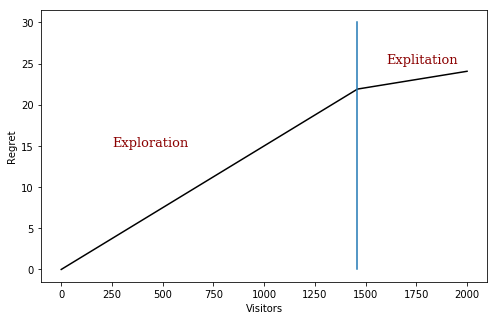

In [3]:
plt.figure(figsize = (8,5)) # plot results
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 13,
        }
plt.plot(vistorsIncreasing,regret,'k-')
plt.plot(old_turning_point* np.ones(30),np.linspace(0,30,num = 30))
plt.xlabel('Visitors')
plt.ylabel('Regret')
plt.text(250, 15, r'Exploration', fontdict=font)
plt.text(1600, 25, r'Explitation', fontdict=font)
plt.show()

# General Exploit/ Explore framework

In [ ]:
# install gekko before running
!pip install gekko

In [4]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
#import matplotlib.animation as animation
from IPython.display import HTML
from gekko import GEKKO

$\frac{dE}{dt} = \frac{L*f_{max}}{K_L+L} - m -u(t)$ 

$\frac{dL}{dt} = u(t)*\alpha - m_L*L$

$E \qquad-$ Subject energy

$L \qquad-$ Exist knowledge

$K_L \qquad -$ Spatial unpredictability constant

$m \qquad-$ Maintenance costs for energy loss

$u(t)\quad -$ knowledge gain (This also leads energy loss)

$\alpha \qquad -$ Efficiency of knowledge gain 

$m_L \qquad -$ Maintenance costs for knowledge loss constant

$f_{max} \qquad -$ Max energy acquisition

min $-E(t)$

Subject to :

$\qquad \frac{dE}{dt} = \frac{L*f_{max}}{K_L+L} - m -u(t) \\
\qquad \frac{dL}{dt} = u(t)*\alpha - m_L*L\\
\qquad E(0) =5.5\\
\qquad E(t) \geq 5\\
\qquad L(0) = 0\\
\qquad L(t) \geq 0 \\
\qquad m = 0.02 \\
\qquad  0.01 \leq m_L \leq 1 \\
\qquad  0.5 \leq f_{max} \leq 10 \\
\qquad  0 \leq u(t) \leq f_{max}  \\
\qquad 0.5 \leq \alpha \leq 10\\
\qquad 0.001 \leq K_L \leq 10\\ 
\qquad 0 \leq u(t) \leq 1$


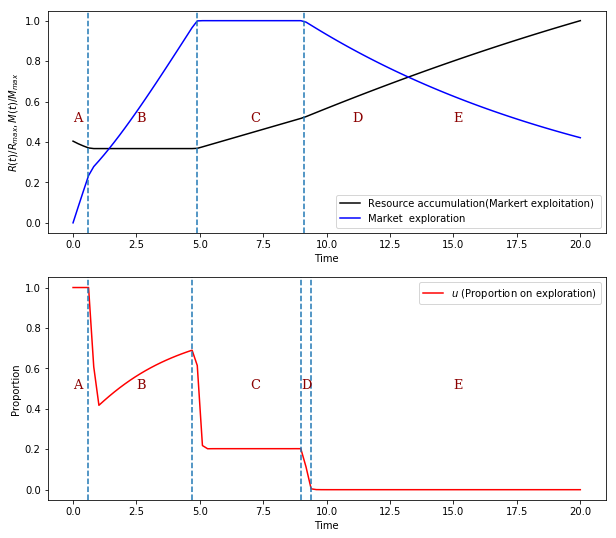

In [8]:
#Create GEKKO model
tradeOff = GEKKO()
#time points
n = 99
tradeOff.time = np.linspace(0,20,n)
#constants
m = 0.02 
m_L = 0.08
f_max = 1
k_L = 6.5
alpha = 6.5

# Variables
E = tradeOff.Var(value = 5.5, lb = 5 )# inital value of E and lower bound of E
L = tradeOff.Var(value = 0, lb = 0)
u = tradeOff.Var(value = 1, lb = 0, ub = min([f_max,1]))# inital value,lower bound and upper bound of u(t)
# mark final time point
p = np.zeros(n) 
p[-1] = 1
final = tradeOff.Param(value=p)
#equation
tradeOff.Equation(E.dt()== f_max*L/(k_L+L) -m -u)
tradeOff.Equation(L.dt()== alpha*u -m_L*L)
# Objective function
tradeOff.Obj(-E*final)
# optimal control mode
tradeOff.options.IMODE = 6
tradeOff.solve(disp=False) # solve


plt.figure(figsize = (10,9)) # plot results
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 13,
        }
plt.subplot(2,1,1)
plt.plot(tradeOff.time,[x / max(E.value) for x in E.value],'k-',label=r'Resource accumulation(Markert exploitation) ')
plt.plot(tradeOff.time,[x / max(L.value) for x in L.value],'b-',label=r'Market  exploration')
plt.xlabel('Time')
plt.ylabel('$R(t)/R_{max},M(t)/M_{max}$')
plt.axvline(x=0.6,linestyle ='--')
plt.axvline(x=4.9,linestyle ='--')
plt.axvline(x=9.1,linestyle ='--')
plt.text(0.0, 0.5, r'A', fontdict=font)
plt.text(2.5, 0.5, r'B', fontdict=font)
plt.text(7, 0.5, r'C', fontdict=font)
plt.text(11, 0.5, r'D', fontdict=font)
plt.text(15, 0.5, r'E', fontdict=font)
plt.legend()
plt.subplot(2,1,2)
plt.plot(tradeOff.time,u.value,'r-',label=r'$u$ (Proportion on exploration)')
plt.axvline(x=0.6,linestyle ='--')
plt.axvline(x=4.7,linestyle ='--')
plt.axvline(x=9,linestyle ='--')
plt.axvline(x=9.4,linestyle ='--')
plt.text(0.0, 0.5, r'A', fontdict=font)
plt.text(2.5, 0.5, r'B', fontdict=font)
plt.text(7, 0.5, r'C', fontdict=font)
plt.text(9, 0.5, r'D', fontdict=font)
plt.text(15, 0.5, r'E', fontdict=font)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Proportion')
plt.show()

In [15]:
'''from graphviz import Digraph
import pandas as pd

G = Digraph(format='jpeg')

G.attr(rankdir='LR', size='8,5')
G.attr('node', shape='circle')

df = pd.read_csv('data.txt', sep=",", engine='python')

nodelist = []
for idx, row in df.iterrows():
    node1, node2, weight = [str(i) for i in row]

    if node1 not in nodelist:
        G.node(node1)
        nodelist.append(node2)
    if node2 not in nodelist:
        G.node(node2)
        nodelist.append(node2)

    G.edge(node1,node2, label = weight)
G.view()#render('sg', view=True)'''

'Digraph.gv.jpeg'

# Complete graph

A complete graph is a simple graph in which each distinct pair of vertices is joined by an edge

In [2]:
import itertools as it
neual_node=[]
#neual_node=[('T',),('a1','a2','a3','a4'),('b1','b2','b3','b4'),('c1', 'c2', 'c3', 'c4'),('d1', 'd2', 'd3', 'd4'),('E',)]   
with open("neual.txt", "r") as f:
    for line in f:
        neual_node.append(tuple(line.split()))# Add neual node from text file
neual_edge=[]
nodelist = list(it.chain(*neual_node))
# nodelist =['T', 'a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4', 'c1', 'c2', 'c3', 'c4', 'd1', 'd2', 'd3', 'd4', 'E']
for index,node in enumerate(nodelist):
    if index< len(nodelist)-1:
        i = index
        while i < len(nodelist):
            b = nodelist[i]
            i+=1
            neual_edge.append((node,b))        

In [3]:
pos ={}
for index,layer in enumerate(neual_node):  
    for i,data in enumerate(layer):
        if index == 0 or index ==len(neual_node)-1:
            pos[data] = (index, 1.5)
        else:
            pos[data] = (index,i) # 8 neurons in the input layer
pos

{'E': (5, 1.5),
 'T': (0, 1.5),
 'a1': (1, 0),
 'a2': (1, 1),
 'a3': (1, 2),
 'a4': (1, 3),
 'b1': (2, 0),
 'b2': (2, 1),
 'b3': (2, 2),
 'b4': (2, 3),
 'c1': (3, 0),
 'c2': (3, 1),
 'c3': (3, 2),
 'c4': (3, 3),
 'd1': (4, 0),
 'd2': (4, 1),
 'd3': (4, 2),
 'd4': (4, 3)}

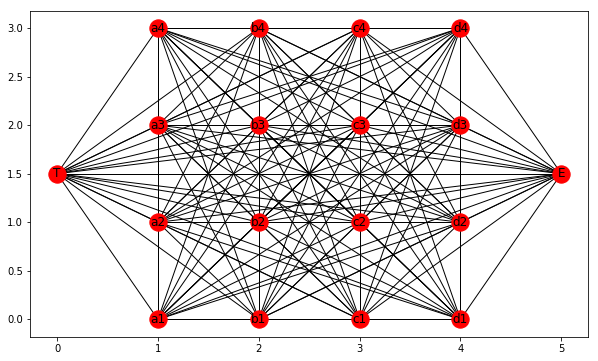

In [4]:
import networkx as nx
from matplotlib import pyplot as plt
%matplotlib inline

G = nx.Graph()
G.add_edges_from(neual_edge)
plt.figure(figsize = (10,6)) # plot results
plt.subplot(111)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G,pos,edgelist=neual_edge)
plt.show()

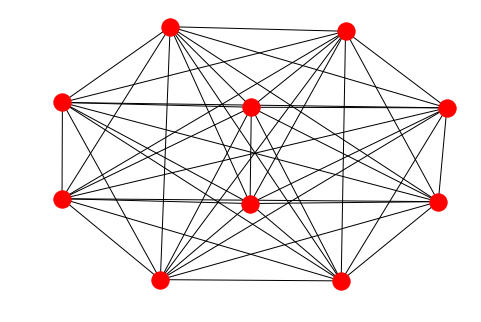

In [46]:
G = nx.complete_graph(10)
nx.draw(G)

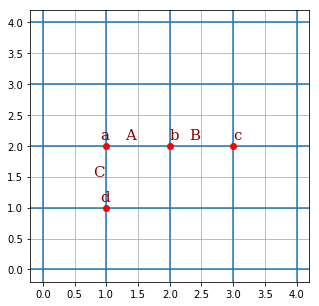

In [43]:
plt.figure(figsize=(5,5))
plt.axvline(x=0)
plt.axvline(x=1)
plt.axvline(x=2)
plt.axvline(x=3)
plt.axvline(x=4)
plt.axhline(y=0)
plt.axhline(y=1)
plt.axhline(y=2)
plt.axhline(y=3)
plt.axhline(y=4)
plt.plot(3,2,'ro')
plt.plot(1,2,'ro')
plt.plot(2,2,'ro')
plt.plot(1,1,'ro')
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 15,
        }
plt.text(1.3, 2.1, r'A', fontdict=font)
plt.text(0.8, 1.5, r'C', fontdict=font)
plt.text(2.3, 2.1, r'B', fontdict=font)
plt.text(0.9, 2.1, r'a', fontdict=font)
plt.text(0.9, 1.1, r'd', fontdict=font)
plt.text(2.0, 2.1, r'b', fontdict=font)
plt.text(3.0, 2.1, r'c', fontdict=font)
plt.grid()
plt.show()

# Business model

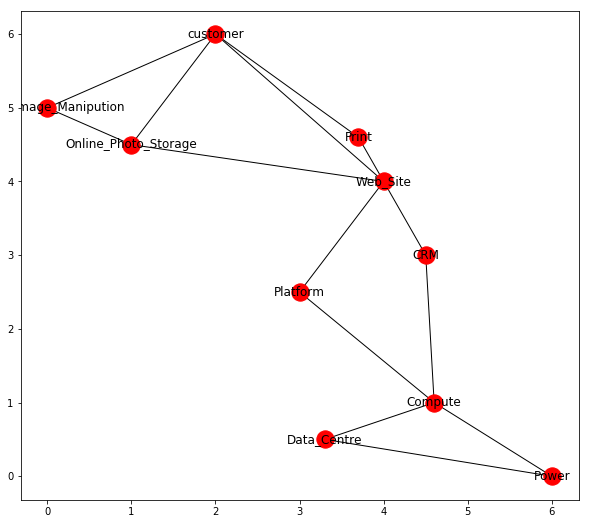

In [10]:
doctrine_node = ['customer', 'Online_Image_Manipution', 'Online_Photo_Storage', 
                 'Web_Site', 'Print','Platform', 'CRM', 'Compute', 'Data_Centre', 'Power']
doctrine_edge =[('customer', 'Online_Image_Manipution'),('customer', 'Online_Photo_Storage'),('customer', 'Web_Site'),( 'customer', 'Print'),
                ('Online_Image_Manipution', 'Online_Photo_Storage'),('Online_Photo_Storage', 'Web_Site'),( 'Web_Site', 'Print'),
                ('Web_Site', 'Platform'),('Web_Site', 'CRM'),('Platform','Compute'),
                ('CRM','Compute'),('Compute','Data_Centre'),('Compute','Power'),('Data_Centre','Power')]
Doctrine = nx.Graph()
Doctrine.add_edges_from([doctrine_edge[0],doctrine_edge[4],doctrine_edge[6],doctrine_edge[8]], weight = 0.5)
Doctrine.add_edges_from([doctrine_edge[1],doctrine_edge[11]], weight = 1)
Doctrine.add_edges_from([doctrine_edge[2],doctrine_edge[9],doctrine_edge[10]], weight = 2)
Doctrine.add_edges_from([doctrine_edge[3],doctrine_edge[7],doctrine_edge[12]], weight = 1.5)
Doctrine.add_edges_from([doctrine_edge[5],doctrine_edge[13]], weight = 2.5)
Doctrine_pos={doctrine_node[0]:(2,6),
              doctrine_node[1]:(0,5),
              doctrine_node[2]:(1,4.5),
              doctrine_node[3]:(4,4),
              doctrine_node[4]:(3.7,4.6),
              doctrine_node[5]:(3,2.5),
              doctrine_node[6]:(4.5,3),
              doctrine_node[7]:(4.6,1),
              doctrine_node[8]:(3.3,0.5),
              doctrine_node[9]:(6,0)}

plt.figure(figsize = (10,9)) # plot results
plt.subplot(111)
nx.draw_networkx_nodes(Doctrine,Doctrine_pos)
nx.draw_networkx_labels(Doctrine, Doctrine_pos)
nx.draw_networkx_edges(Doctrine,Doctrine_pos,edgelist=doctrine_edge)
plt.show()

In [25]:
max(dict(Doctrine.degree()).values())
import operator
max(dict(Doctrine.degree()).items(), key=operator.itemgetter(1))#[0]#return the node with max degree

('Web_Site', 5)

# Toy model with algorithm 1

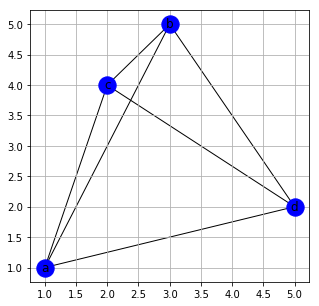

In [1]:
import networkx as nx
from matplotlib import pyplot as plt
%matplotlib inline
G = nx.Graph() # A two-dimensional grid graph 
#G = nx.grid_2d_graph(5, 5)
G.add_nodes_from(['a','b','c','d'])
G.add_edges_from([(x,y)for x in ['a','b','c','d'] for y in ['a','b','c','d']])
pos={'a':(1,1),
     'b':(3,5),
     'c':(2,4),
     'd':(5,2)}
#G.add_edges_from([(x,y) for x in range(3) for y in range(3)])
plt.figure(figsize = (5,5))
plt.grid('True')
nx.draw_networkx_nodes(G,pos = pos,node_color='blue')
nx.draw_networkx_labels(G, pos = pos)
nx.draw_networkx_edges(G, pos = pos)

In [ ]:
def edge_environment(nodes_num):
#This function try to create environment for edge, we give a matrix for all horizontal edges, second matrix for all vertical edges 
# The third matrix for edge from left up to right down, and the fourth matrix for edge from right up to left down.
    horizontal_edges=np.zeros((nodes_num-1,nodes_num))
    vertical_edges=np.zeros((nodes_num,nodes_num-1))
    leftDown_edges=np.zeros((nodes_num-1,nodes_num-1))#from left up to right down
    rightDown_edges=np.zeros((nodes_num-1,nodes_num-1))#from right up to left down
    

We set node energy as $node_{energy} = b-a(x+y)$ where $b$ and $a$ are constant

We set edge energy as the length of energy, so $edge_{energy} = \sqrt{(x_1 - x_2)^2 + (y_1 -y_2)^2}$

We set the rate of cost of transfer as $\frac{d Cost}{dx} = cx$, where $c$ is constant. So the cost of transfer between point $t_1$ and $t_2$ is integral from $t_1$ to $t_2$, which is $cost_{t_1 -> t_2} = || \int_{t_1}^{t_2} cx|| =|| \frac{1}{2}c(t_2^2 -t_1^2)||$ 

We assume a = 0.3, b = 15 and c = 15 first

In [22]:
import numpy as np

def create_environment_nosie():
    #This function try to some noise inside the environment, 
    #which means that some points may have really high values and some points may only have lower points
    noise_dict = {}
    np.random.seed(1314)
    for i in range(13):
        x = np.random.randint(0,100)
        y = np.random.randint(0,100)
        value = np.random.randint(0,3000)
        noise_dict[(x,y)] = value
    return noise_dict

In [21]:
#test function
print(create_environment_nosie())

{(69, 27): 2299, (40, 76): 1605, (82, 32): 1423, (68, 39): 2779, (74, 45): 822, (46, 34): 11, (51, 47): 1506, (86, 75): 463, (15, 35): 359, (94, 15): 1628, (58, 45): 2931, (13, 41): 1653, (21, 65): 1253}


In [248]:
def node_energy(nodes_x_coordinate, nodes_y_coordinate,index):
    #This function setting the nodes environment and noise inside environment 
    #input x coordinate value and y coordinate value. And the index mentions which node should be changed this time
    #output a vector of node energy 
    #node can move back or foward. we record all change of nodes in a vector for easy calculation.
    # we have two different vector list one for x, and another one for y
    node_x = nodes_x_coordinate[index]
    node_y =nodes_y_coordinate[index]
    x_change_list = [node_x-1, node_x, node_x+1]
    y_change_list = [node_y-1, node_y, node_y+1]
    noise_dict = create_environment_nosie()
    selected_node_after_change =[]
    unselected_nodes_energy = []
    for x in x_change_list:
        for y in y_change_list:
            if x<0 or y< 0 or x>100 or y>100:
                selected_node_after_change.append(10000)
                # we set a really high value for negative part to make sure that the points not go to negative environment
            elif (x,y) in noise_dict:
                selected_node_after_change.append(noise_dict[(x,y)])# noise
            else:
                selected_node_after_change.append(500 -x -np.sqrt(y))# enery for selected node with moving left, no moving and moving right
    for i,x in enumerate(nodes_x_coordinate):
        for j,y in enumerate(nodes_y_coordinate):
                if i==j !=index:
                    if x<0 or y< 0 or x>100 or y>100:
                        unselected_nodes_energy.append(10000)
                        # we set a really high value for negative part to make sure that the points not go to negative environment
                    elif (x,y) in noise_dict:
                        unselected_nodes_energy.append(noise_dict[(x,y)])# noise
                    else:
                        unselected_nodes_energy.append(500 -x -np.sqrt(y))
    energy = [x+sum(unselected_nodes_energy) for x in selected_node_after_change]
    return  np.reshape(energy,(3,3))# node_energy = b-a(x+y) right now

In [249]:
#test function 
#x =[1,3,2,5]
#y =[1,5,4,2]
x =[15,1,3]
y =[0,2,2]
print(node_energy(x,y,0))
print('-----')
print(node_energy(x,y,1))
print('-----')
print(node_energy(x,y,2))

[[12116.  2602.  2601.]
 [12116.  2601.  2600.]
 [12116.  2600.  2599.]]
-----
[[1458.         1457.58578644 1457.26794919]
 [1457.         2601.         1456.26794919]
 [1483.         1455.58578644 1455.26794919]]
-----
[[2651.         2623.58578644 2623.26794919]
 [2623.         2601.         4219.        ]
 [2622.         2621.58578644 2621.26794919]]


In [123]:
def transfer_cost(node_x,node_y):
    #input x coordinate value and y coordinate value of one node
    #output a vector of transsfer cost
    #node can move back or foward. we record all change of nodes in a vector for easy calculation.
    # we have two different vector list one for x, and another one for y
    x_change_list = [node_x-1, node_x, node_x+1]
    y_change_list = [node_y-1, node_y, node_y+1]
    return [ 100 - 4.5*t for t in x_change_list]# transfer_cost = 0.5*abs(t1^2 -t2^2) right now   1.5* abs(t**2 -node_x**2)

In [149]:
#test function 
#x =[1,3,2,5]
#y =[1,5,4,2]
x=15
y=2
print(transfer_cost(x,y))

[37.0, 32.5, 28.0]


In [150]:
def edge_matrix(nodes_xORy_coordinate, index):
    matrix = []
    for change in [-1,0,1]:
        new_nodes = [*nodes_xORy_coordinate]
        new_nodes[index]+= change
        node_list = [(x1 -x2)**2 for index_x1,x1 in enumerate(new_nodes) for index_x2,x2 in enumerate(new_nodes) if index_x1<index_x2]
        matrix.append(node_list)  
    return matrix 
#output: [value(x-1), value(x), value(x+1)]

In [151]:
#test function 
x =[1,1,3]
y =[1,2,2]
print(edge_matrix(x,0))
print(edge_matrix(y,0))
print('-----')
print(edge_matrix(x,1))
print(edge_matrix(y,1))
print('-----')
print(edge_matrix(x,2))
print(edge_matrix(y,2))

[[1, 9, 4], [0, 4, 4], [1, 1, 4]]
[[4, 4, 0], [1, 1, 0], [0, 0, 0]]
-----
[[1, 4, 9], [0, 4, 4], [1, 4, 1]]
[[0, 1, 1], [1, 1, 0], [4, 1, 1]]
-----
[[0, 1, 1], [0, 4, 4], [0, 9, 9]]
[[1, 0, 1], [1, 1, 0], [1, 4, 1]]


In [188]:
import numpy as np        
def edge_energy(nodes_x_coordinate, nodes_y_coordinate, index):
    #input all nodes_x_coordinate and nodes_y_coordinate list, and a index to tell the function which node is been dealing now.
    #output a 3*3 matrix for all probability of node moving
    x_matrix = edge_matrix(nodes_x_coordinate, index)
    y_matrix = edge_matrix(nodes_y_coordinate, index)
    energy = [np.sum(np.sqrt(np.add(x,y))) for x in x_matrix for y in y_matrix]
    energy = np.reshape(energy,(3,3))
    return energy 

In [250]:
#test function 
x =[15,1,3]
y =[15,1,15]
print(edge_energy(x,y,0))
print(edge_energy(x,y,1))
print(edge_energy(x,y,2))

[[43.57227295 44.2471088  45.03692988]
 [45.28870338 45.9411255  46.70201473]
 [47.02997368 47.66042015 48.39374387]]
[[48.51026198 46.83610559 45.19109731]
 [47.65103048 45.9411255  44.25791961]
 [46.88272962 45.14064202 43.42318112]]
[[45.87579949 46.83465872 47.87069106]
 [44.99353089 45.9411255  46.9733304 ]
 [44.18601495 45.11681094 46.14140943]]


The output matrix of node_matrix is:

$\begin{bmatrix}
    value(x_k-1)\\
    value(x_k)\\
    value(x_k+1)\\
\end{bmatrix} =
\begin{bmatrix}
    x_1-x_2 & \dots  & (x_k-1)-x_l & \dots & x_j-x_m & \dots\\
    x_1-x_2 & \dots  &  x_k-x_l & \dots & x_j-x_m & \dots\\
    x_1-x_2 & \dots  & (x_k+1)-x_l & \dots & x_j-x_m & \dots\\
\end{bmatrix}$
where $ j<m \leq n $

The output matrix of edge_energy is:

$\begin{bmatrix}
    value(x-1,y-1)  & value(x-1,y)  & value(x-1,y+1)\\
    value(x,y-1)   & value(x,y)   & value(x,y+1)\\
    value(x+1,y-1)  & value(x+1,y) & value(x+1,y+1)\\
\end{bmatrix}$

In [154]:
def total_energy(nodes_x_coordinate, nodes_y_coordinate):
    total_energy_matrix = []
    for index,data in enumerate(nodes_x_coordinate):
        edge =edge_energy(nodes_x_coordinate, nodes_y_coordinate, index)
        #node = np.array([node_energy(data,nodes_y_coordinate[index])]).T
        node = node_energy(nodes_x_coordinate, nodes_y_coordinate,index)
        transfer = np.array([transfer_cost(data,nodes_y_coordinate[index])]).T
        total_energy_for_this_index = np.add(transfer, np.add(node,edge))
        total_energy_matrix.append(total_energy_for_this_index)
    return total_energy_matrix   

In [155]:
#test function 
x =[1,1,3]
y =[1,2,2]
print(total_energy(x,y))

[array([[151.84161925, 150.07649122, 149.        ],
       [145.82842712, 143.73606798, 142.        ],
       [140.47213595, 138.32842712, 137.        ]]), array([[150.39834564, 150.15028154, 150.63441362],
       [143.47213595, 143.73606798, 130.47213595],
       [138.65028154, 138.15028154, 138.88634952]]), array([[138.41421356, 137.91421356, 138.65028154],
       [135.23606798, 134.73606798, 135.0644951 ],
       [132.16227766, 131.66227766, 131.76782894]])]


In [34]:
#this function can deal with list type or dict type, 
#and ths function try to get the x coordinate and y coordinate in two different lists for all the nodes.
def get_xy_coordinate(points_list):
    nodes_x_coordinate =[]
    nodes_y_coordinate =[]
    if type(points_list) == dict: 
        points_list = list(points_list.values())
        #if input is a dict, we can still deal with it
    for data in points_list:
        nodes_x_coordinate.append(data[0])
        nodes_y_coordinate.append(data[1])
    return nodes_x_coordinate,nodes_y_coordinate
        

In [35]:
def pos_output(index,pos):
    #This function try to update pos
    index_should_change = int(index/9)# classify which point should been changed the position 
    old_value =pos[list(pos.keys())[index_should_change]] # get the original tuple value 
    x=0
    y=0
    if index%9 == 0:
        x = -1
        y = 1
        
    elif index%9 == 1:
        x = 0
        y = 1
    elif index%9 == 2:
        x = 1
        y = 1
    elif index%9 == 3:
        x = -1
        y = 0
    elif index%9 == 4:
        x = 0
        y = 0
    elif index%9 == 5:
        x = 1
        y = 0
    elif index%9 == 6:
        x = -1
        y = -1
    elif index%9 == 7:
        x = 0
        y = -1
    elif index%9 == 8:
        x = 1
        y = -1
        
    x_value = old_value[0]+x
    y_value = old_value[1]+y

    pos[list(pos.keys())[index_should_change]] =(x_value,y_value)

    return pos    

In [253]:
import copy
#Everytime we only move one step, we iternate it for finding the local minimum value
pos={'a':(9,4),
     'b':(4,13),
     'c':(3,11),
     'd':(3,8)}# the initial points dict we get now
continuous_iter = True # This sentence to control and stop the iteration 
cache_for_each_step ={}#This dict will record minimum energy and the points' position  at each step,
#and energy is key , the points' position is values
energy_now = 50000# we initial energy as a realy large value
iter_num = 0
while continuous_iter == True:
    iter_num +=1
    nodes_x_coordinate, nodes_y_coordinate = get_xy_coordinate(pos)
    total_energy_matrix = total_energy(nodes_x_coordinate, nodes_y_coordinate)
    total_energy_list = [num for path in total_energy_matrix for item in path for num in item]# transfrom matrix to list for easy sorting
    new_min_energy = min(total_energy_list)
    new_min_index = total_energy_list.index(new_min_energy)
    if energy_now < new_min_energy:
        print('stop1')
        continuous_iter = False
        break
    elif abs(energy_now - new_min_energy)< 10e-8:
        print('stop2')
        continuous_iter = False
        break
    elif iter_num >100:
        continuous_iter = False
        break
    new_pos = copy.deepcopy(pos_output(new_min_index,pos))
    energy_now = new_min_energy
    cache_for_each_step[new_min_energy] = new_pos

stop1


In [254]:
print(cache_for_each_step.keys())

dict_keys([2060.183733886184, 2059.0606562742523, 2057.9959066876036, 2056.99846897847, 2056.109457210064, 2055.814896364409])


In [26]:
import networkx as nx
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize = (5,5))
plt.plot(list(cache_for_each_step.keys()),'o-')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

NameError: name 'cache_for_each_step' is not defined

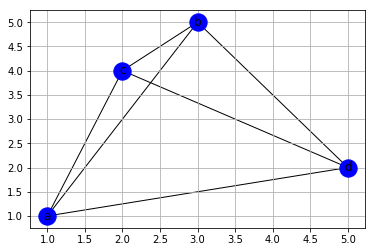

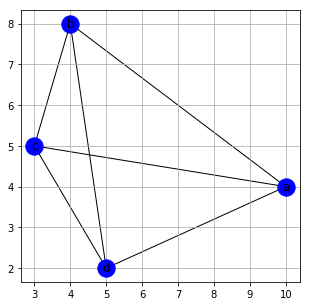

In [104]:
import matplotlib.animation as animation
# This part try to product the animation

G = nx.Graph() 
# random ndarray between 0 and 5, length and number of frames = number of nodes in the graph
G.add_nodes_from(['a','b','c','d'])
G.add_edges_from([(x,y)for x in ['a','b','c','d'] for y in ['a','b','c','d']])
pos={'a':(1,1),
     'b':(3,5),
     'c':(2,4),
     'd':(5,2)}
nodes = nx.draw_networkx_nodes(G,pos = pos,node_color='blue')
labels = nx.draw_networkx_labels(G, pos = pos)
edges = nx.draw_networkx_edges(G, pos = pos)
#plt.figure(figsize = (5,5))
plt.grid('True')
plt.axis('auto')
    
def update(i):
    ax.clear()
    # for i in range(len(frame)):
    # instead of giving frame as input, if I randomly generate it, then it works
    pos_now = list(cache_for_each_step.values())[i]
    nodes = nx.draw_networkx_nodes(G,pos_now,node_color='blue',ax=ax)
    labels = nx.draw_networkx_labels(G, pos_now, ax=ax)
    edges = nx.draw_networkx_edges(G, pos_now,ax=ax)
    plt.grid('True')
    return nodes,labels,edges,

fig, ax = plt.subplots(figsize = (5,5))
ani = animation.FuncAnimation(fig, update, interval= len(cache_for_each_step.values()), 
                              frames= range(len(cache_for_each_step.values())), blit=False)
ani.save('try.mp4', fps=1)

# Toy model with algorithm 2